In [1]:
from data_generator import *
import pandas as pd
from ast import literal_eval

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from NN_helpers import *
import matplotlib.pyplot as plt


In [3]:
test_map ="""wwwwwwwwwwwweeewwwwwwwwwww
w  s b    w     w b   b  w
w         w     w        w
w         w     w        w
w         w     w        w
w         w              w
w                        w
w2              w        w
w         wb    w      s w
wwwwwww  wwb    wwwwwwwwww
w s b     wb           b w
w         wb           b w
w         wb   ww        w
w         wb   ww        w
w         w    wwwww wwwww
wwwwwwwwwww    ww3    b  w
e              ww        w
e              ww        e
e                        w
e                        w
wwwwwwwwwww    www  wwwwww
ws b   b  w    wb      b w
w         w    w       b w
w         w    w       b w
w         w    w         w
w         w    w         w
www  wwwwww    wwwwww  www
w               b wb   b w
w                 w      w
w     b   w       w      w
w1        wr      w      w
w         w       w     sw
wwwwwwwwwwwwweeewwwwwwwwww"""

In [4]:
data, G, obj_dir = generate(test_map, 20)
data['run'] = 0
for i in range(1,10):
    d2, G, obj_dir = generate(test_map, 20)
    d2['run'] = i
    data = data.append(d2,ignore_index=True)

In [59]:
data, G, obj_dir = generate(test_map, 20)
data['run'] = 0

In [60]:
data = data.sort_values(['run','agent','time'])

In [61]:
data = data.reset_index()

In [62]:
data_linear = data.copy()
data_linear['true_agent_loc'] = data_linear['agent_loc']
data_linear['predict_loc'] = [(0,0)]*len(data_linear)
data_linear['prediction'] = [[0,0,0,0,0]]*len(data_linear)
for idx in data_linear.index:
    if data_linear.at[idx, 'time'] > 1:
        data_linear.at[idx, 'prediction'] = data_linear.at[idx-1, 'direction']
data_linear = data_linear.drop(list(data_linear[data_linear.time<2].index))

In [63]:
for i in range(data.shape[0]):
    if data.loc[i]['time'] > 5:
        data.loc[i,'sample1'] = data.loc[i-1]['query_state']
        data.loc[i,'sample2'] = data.loc[i-2]['query_state'] 
        data.loc[i,'sample3'] = data.loc[i-3]['query_state'] 
        data.loc[i,'sample4'] = data.loc[i-4]['query_state']
        data.loc[i,'sample5'] = data.loc[i-5]['query_state']

        
data = data.dropna()
data['predict_loc'] = [(0,0)]*len(data)
data['true_agent_loc'] = data['agent_loc']

In [64]:
#data.target = data.direction.apply(literal_eval)
data.sample1 = data.sample1.fillna('[]').apply(literal_eval)
data.sample2 = data.sample2.fillna('[]').apply(literal_eval)
data.sample3 = data.sample3.fillna('[]').apply(literal_eval)
data.sample4 = data.sample4.fillna('[]').apply(literal_eval)
data.sample5 = data.sample5.fillna('[]').apply(literal_eval)
data.query_state = data.fillna('[]').query_state.apply(literal_eval)

In [65]:
model = Net()
model.load_state_dict(torch.load('network2'))
model.eval()

Net(
  (conv_1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (l_sample): Linear(in_features=200, out_features=121, bias=True)
  (conv_2): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=400, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=5, bias=False)
)

In [66]:
def predict_linear(data):
    for idx in data.index:
        data.at[idx,'predict_loc'] = pred_to_action(data.at[idx,'prediction'].index(1),data.at[idx,'agent_loc'])
        data.at[idx,'accuracy'] = data.at[idx,'prediction']==data.at[idx,'direction']
        data.at[idx,'pos_acc'] = data.at[idx,'agent_loc']==data.at[idx,'true_agent_loc']
        if euclidean_dist(data.at[idx,'agent_loc'], data.at[idx,'true_agent_loc']) < 3:
            data.at[idx,'pos_acc_2'] = 1
        else:
            data.at[idx,'pos_acc_2'] = 0
    return data

In [67]:
def linear_data(data):
    data_2 = data.copy()
    min_time = min(data.time)
    for idx in data.index:
        if data_2.at[idx, 'time'] > min_time:
            data_2.at[idx,'prediction'] = data.at[idx-1,'prediction']
            data_2.at[idx,'agent_loc'] = data.at[idx-1,'predict_loc']
    data_2 = data_2.drop(list(data_2[data_2.time==min_time].index))
    return data_2

In [68]:
euclidean_dist((0,0),(2,2))

2.8284271247461903

In [69]:
from heuristics import *

In [70]:
acc = []
acc_2 = []
acc_linear = []
acc_linear_2 = []
for i in range(0,16):
    #make predictions
    data = predict_data(data, model)
    data_linear = predict_linear(data_linear)
    #evaluate predictions
    print('Prediction for time step ' + str(i))
    print(data.shape)
    print(sum(data.accuracy == 1)/(sum(data.accuracy==0)+sum(data.accuracy == 1)))
    print(sum(data.pos_acc == 1)/(sum(data.pos_acc==0)+sum(data.pos_acc == 1)))
    print(sum((data.pos_acc == 1) & (data.accuracy == 1))/data.shape[0])
    print(sum((data.pos_acc == 1) & (data.accuracy == 1))/sum(data.pos_acc == 1))
    print(sum(data.pos_acc_2 == 1)/(sum(data.pos_acc_2==0)+sum(data.pos_acc_2 == 1)))
    acc.append(sum((data.pos_acc == 1) & (data.accuracy == 1))/data.shape[0])
    acc_2.append(sum(data.pos_acc_2 == 1)/(sum(data.pos_acc_2==0)+sum(data.pos_acc_2 == 1)))
    
    
    #evaluate linear predictions
    print('Prediction for time step ' + str(i))
    print(data_linear.shape)
    print(sum(data_linear.accuracy == 1)/(sum(data_linear.accuracy==0)+sum(data_linear.accuracy == 1)))
    print(sum(data_linear.pos_acc == 1)/(sum(data_linear.pos_acc==0)+sum(data_linear.pos_acc == 1)))
    print(sum((data_linear.pos_acc == 1) & (data_linear.accuracy == 1))/data_linear.shape[0])
    acc_linear.append(sum((data_linear.pos_acc == 1) & (data_linear.accuracy == 1))/data_linear.shape[0])
    print(sum(data_linear.pos_acc_2 == 1)/(sum(data_linear.pos_acc_2==0)+sum(data_linear.pos_acc_2 == 1)))
    acc_linear_2.append(sum(data_linear.pos_acc_2 == 1)/(sum(data_linear.pos_acc_2==0)+sum(data_linear.pos_acc_2 == 1)))
    
    #make data ready for new predictions
    data = data_from_prediction(data, G, obj_dir)
    data_linear = linear_data(data_linear)

Prediction for time step 0
(634, 19)
0.9400630914826499
1.0
0.9400630914826499
0.9400630914826499
1.0
Prediction for time step 0
(730, 14)
0.7438356164383562
1.0
0.7438356164383562
1.0
Prediction for time step 1
(610, 19)
0.9065573770491804
0.9393442622950819
0.8852459016393442
0.9424083769633508
1.0
Prediction for time step 1
(706, 14)
0.7478753541076487
0.7492917847025495
0.6274787535410765
1.0
Prediction for time step 2
(586, 19)
0.8686006825938567
0.8959044368600683
0.8361774744027304
0.9333333333333333
0.9880546075085325
Prediction for time step 2
(682, 14)
0.7126099706744868
0.6348973607038123
0.533724340175953
0.9926686217008798
Prediction for time step 3
(562, 19)
0.8327402135231317
0.8487544483985765
0.7882562277580071
0.9287211740041929
0.9661921708185054
Prediction for time step 3
(658, 14)
0.6793313069908815
0.5379939209726444
0.44376899696048633
0.8844984802431611
Prediction for time step 4
(538, 19)
0.8048327137546468
0.8122676579925651
0.7527881040892194
0.92677345537757

In [37]:
data.loc[20].sample1[0] == data.loc[20].sample2[0]

False

In [108]:
4**25

1125899906842624

In [27]:
sum(([item in data_all_correct for item in data.index]) & (data.accuracy==1))

636

In [78]:
data_test = pd.read_csv('test_new.csv')

In [79]:
#data_test = data_test[data_test.run==2]
#data.target = data.direction.apply(literal_eval)
data_test.sample1 = data_test.sample1.fillna('[]').apply(literal_eval)
data_test.sample2 = data_test.sample2.fillna('[]').apply(literal_eval)
data_test.sample3 = data_test.sample3.fillna('[]').apply(literal_eval)
data_test.sample4 = data_test.sample4.fillna('[]').apply(literal_eval)
data_test.sample5 = data_test.sample5.fillna('[]').apply(literal_eval)
data_test.query_state = data_test.query_state.fillna('[]').apply(literal_eval)
data_test.direction = data_test.direction.fillna('[]').apply(literal_eval)
data_test.agent_loc = data_test.agent_loc.fillna('[]').apply(literal_eval)

data_test['predict_loc'] = [(0,0)]*len(data_test)
data_test['true_agent_loc'] = data_test['agent_loc']

In [80]:
data_tes_preds = predict_data(data_test, model)

In [81]:
sum(data_tes_preds.accuracy==1)/data_tes_preds.shape[0]

0.9311283712132068

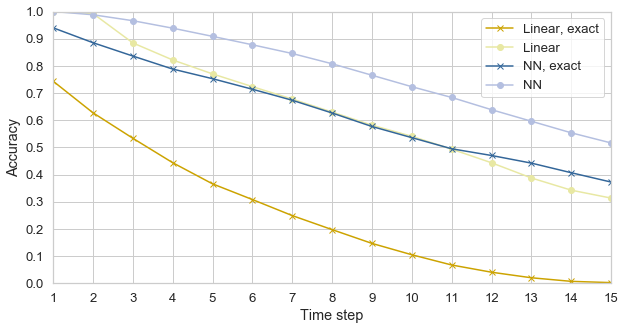

In [90]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set(style='whitegrid',font_scale=1.2)
fig = plt.figure(figsize=(10,5))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_linear[:-1], '-x',label='Linear, exact', color='#CCA300')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_linear_2[1:], '-o',label='Linear', color='#E8E8A3')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], acc[:-1],'-x',label='NN, exact', color='#336699')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],acc_2[1:], '-o',label='NN', color='#B4BFE0')
plt.xlabel('Time step')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.xlim((1,15))
plt.xticks(np.arange(1, 15+1, 1.0))
plt.yticks(np.arange(0, 1+0.05, 0.1))
plt.legend()

In [91]:
fig.savefig('performance.png')